In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, sys
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.stats.api as sms

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [5]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')

In [4]:
from ccs_tools import core_dtypes_pd
from utils import preprocess

Using TensorFlow backend.


In [39]:
data_df = pd.read_csv(path+'cohorts/ami/ami_pred.csv', dtype=core_dtypes_pd)

In [41]:
DX_series = pd.concat([data_df['DX'+str(j)] for j in range(2, 31)])

In [43]:
DX_freq = DX_series.value_counts()

In [60]:
sum(DX_freq>200)/len(DX_freq)

0.13131679043651512

In [61]:
len(DX_series.loc[DX_series.isin(DX_freq.loc[DX_freq>200].index)])/len(DX_series.dropna())

0.9543447444167605

## Prepare hyper-parameters and generate the .sh files

For embedding+NN with all codes:

In [2]:
!rm hypertune*.sh

In [3]:
model_names = ['no_mask']
code_embed_dims = [200]
fc_widths = [512]
md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0, 0.3]
batchsizes = [256]
penalties = [0.]
count_caps = [20]
tst_seeds = range(10)
cohorts = ['ami']
zips = [(embed_dim, tst_fold, cohort, 
         'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(embed_dim, penalty, count_cap, cohort, 
                                                                                    tst_fold)) 
        for embed_dim in code_embed_dims for penalty in penalties for count_cap in count_caps for cohort in cohorts 
        for tst_fold in tst_seeds] 
#zips = zips + [(embed_dim, tst_fold, '') for embed_dim in code_embed_dims for tst_fold in tst_seeds]
sep_dx1s = [1]
val_folds = [7]
rho_widths = [16]
result_files = ['output/ht_result1121_{}.csv']

In [11]:
model_names = ['permutate_hosp']
code_embed_dims = [200]
fc_widths = [512]
md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0]
batchsizes = [256]
penalties = [0.]
count_caps = [20]
tst_seeds = range(10)
cohorts = ['ami']
zips = [(embed_dim, tst_fold, cohort, 
         'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(embed_dim, penalty, count_cap, cohort, 
                                                                                    tst_fold)) 
        for embed_dim in code_embed_dims for penalty in penalties for count_cap in count_caps for cohort in cohorts 
        for tst_fold in tst_seeds] 
#zips = zips + [(embed_dim, tst_fold, '') for embed_dim in code_embed_dims for tst_fold in tst_seeds]
sep_dx1s = [1]
val_folds = [7]
rho_widths = [16]
result_files = ['output/ht_result1121_{}.csv']

In [27]:
model_names = ['batchnorm']
code_embed_dims = [200]
fc_widths = [512]
md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0]
batchsizes = [256]
penalties = [0.]
count_caps = [20]
tst_seeds = range(10)
cohorts = ['ami']
zips = [(embed_dim, tst_fold, cohort, 
         'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(embed_dim, penalty, count_cap, cohort, 
                                                                                    tst_fold)) 
        for embed_dim in code_embed_dims for penalty in penalties for count_cap in count_caps for cohort in cohorts 
        for tst_fold in tst_seeds] 
#zips = zips + [(embed_dim, tst_fold, '') for embed_dim in code_embed_dims for tst_fold in tst_seeds]
sep_dx1s = [1]
val_folds = [7]
rho_widths = [16]
result_files = ['output/ht_result1121_{}.csv']

In [19]:
model_names = ['dense_rho']
code_embed_dims = [200]
fc_widths = [512]
md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0, 0.3]
batchsizes = [256]
penalties = [0., 0.3]
count_caps = [20]
tst_seeds = range(10)
cohorts = ['ami']
zips = [(embed_dim, tst_fold, cohort, 
         'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(embed_dim, penalty, count_cap, cohort, 
                                                                                    tst_fold)) 
        for embed_dim in code_embed_dims for penalty in penalties for count_cap in count_caps for cohort in cohorts 
        for tst_fold in tst_seeds] 
#zips = zips + [(embed_dim, tst_fold, '') for embed_dim in code_embed_dims for tst_fold in tst_seeds]
sep_dx1s = [1]
val_folds = [7]
rho_widths = [16, 32, 64]
result_files = ['output/ht_result1121_{}.csv']

In [12]:
para_itr = itertools.product(model_names, fc_widths, md_widths, lr1s, lr2s, dropouts, batchsizes, zips, sep_dx1s, 
                             val_folds, rho_widths, result_files)

para_lst = [(mo, z[0], fc, md, lr1, lr2, dr, ba, z[3], z[1], z[2], se, va, rw, re) for mo, fc, md, lr1, lr2, dr, ba, z, se, va, rw, re in para_itr]

In [13]:
len(para_lst)

10

In [14]:
n_jobs = 10
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_all0827.py --model_name {} --code_embed_dim {} --fc_width {} --md_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --tst_seed {} --cohort {} --sep_dx1 {} --val_fold {} --rho_width {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [107]:
job_index = 5
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_all0827.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --tst_seed {9} --cohort {10} --sep_dx1 {11} --val_fold {12} --result_file {13} --job_index {14}\n'.format(*para, job_index))

In [9]:
for p in [0, 1, 2, 5]:
    for cc in [20, 100, 500]:
        for f in range(10):
            os.rename(path+'all/sepdx1/embed_mat_200_{:.3f}_{}_{}.npy'.format(p, cc, f), path+'all/sepdx1/embed_mat_200_{:.3f}_{}_ami{}.npy'.format(p, cc, f))

For embedding+NN with a subset of codes:

In [2]:
!rm hypertune*.sh

In [16]:
model_names = ['setsum_nn']
code_embed_dims = [200, 300]
fc_widths = [512, 1024]
md_widths = [128, 256]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0.3]
batchsizes = [256, 512]
embed_mats = ['pretrain']
penalties = [0, 0.5, 1.]
penalty_metrics = ['cosine']
count_caps = [0, 5, 20]
tst_seeds = range(10)
cohorts = ['ami']
DX_rarecutpoints = [20]
PR_rarecutpoints = [drp/2 for drp in DX_rarecutpoints]
val_folds = [5]
result_files = ['output/ht_result1001_{}.csv']

In [8]:
model_names = ['embed_sum', 'embed_pool']
code_embed_dims = [100]
fc_widths = [512]
md_widths = [128]
lr1s = [2e-4]
lr2s = [2e-5]
dropouts = [0.3]
batchsizes = [256]
embed_mats = ['random']
penalties = [0]
penalty_metrics = ['cosine']
count_caps = [5]
tst_seeds = range(10)
cohorts = ['ami']
DX_rarecutpoints = [20]
PR_rarecutpoints = [drp/2 for drp in DX_rarecutpoints]
val_folds = [5]
result_files = ['output/ht_result1001_{}.csv']

In [17]:
para_itr = itertools.product(model_names, code_embed_dims, fc_widths, md_widths, lr1s, lr2s, dropouts, batchsizes, embed_mats, 
                             penalties, penalty_metrics, count_caps, tst_seeds, cohorts, DX_rarecutpoints,
                             val_folds, result_files)
para_lst = [(mn, ced, fc, md, l1, l2, do, bs, em, p, pm, cc, ts, ch, dx, int(dx/2), vf, rf) 
            for mn, ced, fc, md, l1, l2, do, bs, em, p, pm, cc, ts, ch, dx, vf, rf in para_itr]

In [18]:
len(para_lst)

720

In [15]:
n_jobs = 4
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --tst_seed {12} --cohort {13} --dx_rarecutpoint {14} --pr_rarecutpoint {15} --val_fold {16} --result_file {17} --job_index {18}\n'.format(*para, job_ind))

In [107]:
job_index = 5
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --tst_seed {12} --cohort {13} --dx_rarecutpoint {14} --pr_rarecutpoint {15} --val_fold {16} --result_file {17} --job_index {18}\n'.format(*para, job_index))

Random search:

In [4]:
n_sample = 33

In [5]:
model_names = np.random.choice(['setsum_nn'], n_sample)
code_embed_dims = np.random.choice([200, 300], n_sample)
fc_widths = np.random.choice([512, 1024], n_sample)
md_widths = np.random.choice([128, 256], n_sample)
lr1s = np.random.choice([2e-4], n_sample)
lr2s = np.random.choice([2e-5], n_sample)
dropouts = np.random.choice([0.3], n_sample)
batchsizes = np.random.choice([256, 512], n_sample)
embed_mats = np.random.choice(['pretrain'], n_sample)
penalties = np.random.choice([0, 0.5, 1.], n_sample)
penalty_metrics = np.random.choice(['cosine'], n_sample)
count_caps = np.random.choice([0, 5, 20], n_sample)
cohorts = np.random.choice(['ami'], n_sample)
DX_rarecutpoints = np.random.choice([20], n_sample)
PR_rarecutpoints = [int(drp/2) for drp in DX_rarecutpoints]
val_folds = np.random.choice([5], n_sample)
result_files = ['output/ht_result1001_{}.csv']*n_sample

zips = zip(model_names, code_embed_dims, fc_widths, md_widths, lr1s, lr2s, dropouts, batchsizes, embed_mats, 
                             penalties, penalty_metrics, count_caps, cohorts, DX_rarecutpoints, PR_rarecutpoints,
                             val_folds, result_files)
tst_seeds = range(10)

In [6]:
para_itr = itertools.product(zips, tst_seeds)

para_lst = [(*z, t) for z, t in para_itr]

In [7]:
len(para_lst)

330

In [8]:
n_jobs = 4
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --cohort {12} --dx_rarecutpoint {13} --pr_rarecutpoint {14} --val_fold {15} --result_file {16} --tst_seed {17} --job_index {18}\n'.format(*para, job_ind))

For OHE:

In [2]:
!rm hypertune*.sh

In [3]:
fc_width1s = [1024]
fc_width2s = [256]
lrs = [1e-4]
dropouts = [0.3]
batchsizes = [512]
tst_seeds = range(10)
cohorts = ['ami', 'chf', 'pna']
val_folds = [5]
dx_rarecutpoints = [10]
pr_rarecutpoints = [10]
result_files = ['output/ht_result0925_{}.csv']

In [4]:
para_itr = itertools.product(fc_width1s, fc_width2s, lrs, dropouts, batchsizes, tst_seeds, cohorts, val_folds, 
                             dx_rarecutpoints, pr_rarecutpoints, result_files)

para_lst = list(para_itr)

In [5]:
len(para_lst)

30

In [6]:
n_jobs = 1
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_ohe0925.py --fc_width1 {} --fc_width2 {} --lr {} --dropout {} --batchsize {} --tst_seed {} --cohort {} --val_fold {} --dx_rarecutpoint {} --pr_rarecutpoint {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [107]:
job_index = 5
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_all0827.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --tst_seed {9} --cohort {10} --sep_dx1 {11} --val_fold {12} --result_file {13} --job_index {14}\n'.format(*para, job_index))

## Result Analysis

### Embedding + NN with all codes

In [2]:
res = pd.DataFrame()

In [3]:
for job_ind in range(10):
    df = pd.read_csv('output/ht_result1121_'+str(job_ind)+'.csv', 
                     names=['model_name', 'code_embed_dim', 'hosp_embed_dim', 'fc_width', 'md_width', 'lr1', 'lr2', 'dropout',
                            'batchsize', 'embed_file', 'cohort', 'sep_dx1', 'tst_seed', 'n_fold', 'auc_mean', 'auc_avg', 
                            'auc_freeze', 'rho_width', 'y_pred_file'], index_col=None)
    res = pd.concat([res, df])

In [11]:
res = res.assign(cohort_seed=res.cohort+res.tst_seed.apply(lambda x:str(x)))

In [18]:
res = res.drop_duplicates(subset=['cohort_seed'], keep='last')

In [4]:
res

,model_name,code_embed_dim,hosp_embed_dim,fc_width,md_width,lr1,lr2,dropout,batchsize,embed_file,cohort,sep_dx1,tst_seed,n_fold,auc_mean,auc_avg,auc_freeze,rho_width,y_pred_file
0,batchnorm,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7135,0.7198,0.7098,16,output/y_pred_mat18_11_21_10_42_42.npy
1,no_mask,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7193,0.7215,0.7174,16,output/y_pred_mat18_11_22_07_09_18.npy
2,no_mask,200,1,512,128,0.0002,0.00002,0.3,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7193,0.7211,0.7180,16,output/y_pred_mat18_11_22_08_04_24.npy
3,permutate_hosp,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7176,0.7204,0.7163,16,output/y_pred_mat18_11_22_08_59_26.npy
4,dense_rho,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7186,0.7214,0.7178,16,output/y_pred_mat18_11_22_03_15_29.npy
5,dense_rho,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,3,7,0.7181,0.7217,0.7178,32,output/y_pred_mat18_11_22_04_12_47.npy
6,dense_rho,200,1,512,128,0.0002,0.00002,0.0,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,6,7,0.7097,0.7128,0.7094,64,output/y_pred_mat18_11_22_05_10_14.npy
7,dense_rho,200,1,512,128,0.0002,0.00002,0.3,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,0,7,0.7180,0.7209,0.7167,16,output/y_pred_mat18_11_22_06_08_50.npy
8,dense_rho,200,1,512,128,0.0002,0.00002,0.3,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,3,7,0.7181,0.7215,0.7185,32,output/y_pred_mat18_11_22_07_06_23.npy
9,dense_rho,200,1,512,128,0.0002,0.00002,0.3,256,all/sepdx1/test_embed/cosine/embed_mat_200_0.0...,ami,1,6,7,0.7104,0.7132,0.7099,64,output/y_pred_mat18_11_22_08_04_42.npy


In [14]:
res.embed_file.apply(lambda x:x.split('/')[3]).head()

0    cosine
1    cosine
2    cosine
3    cosine
4    cosine
Name: embed_file, dtype: object

In [11]:
res = res.assign(penalty = res.embed_file.apply(lambda x:float(x.split('_')[4])))

In [13]:
res = res.assign(count_cap = res.embed_file.apply(lambda x:float(x.split('_')[5])))

In [15]:
res = res.assign(metric = res.embed_file.apply(lambda x:(x.split('/')[3])))

In [30]:
res = res.loc[res.penalty==0.5]

In [5]:
res_grouped = res.groupby(['model_name', 'dropout', 'rho_width'])

In [6]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze       auc_mean        auc_avg  \
                                       mean count     mean count     mean   
model_name     dropout rho_width                                            
batchnorm      0.0     16           0.70791    10  0.71102    10  0.71813   
dense_rho      0.0     16           0.71814    10  0.71887    10  0.72198   
                       32           0.71817    10  0.71888    10  0.72222   
                       64           0.71808    10  0.71928    10  0.72252   
               0.3     16           0.71810    10  0.71871    10  0.72178   
                       32           0.71784    10  0.71839    10  0.72168   
                       64           0.71818    10  0.71893    10  0.72200   
no_mask        0.0     16           0.71865    10  0.71941    10  0.72208   
               0.3     16           0.71944    10  0.71996    10  0.72212   
permutate_hosp 0.0     16           0.71742    10  0.71868    10  0.72126   

                                        
                                 count  
model_name     dropout rho_width        
batchnorm      0.0     16           10  
dense_rho      0.0     16           10  
                       32           10  
                       64           10  
               0.3     16           10  
                       32           10  
                       64           10  
no_mask        0.0     16           10  
               0.3     16           10  
permutate_hosp 0.0     16           10

In [7]:
for _, g in res_grouped:
    if g.auc_avg.mean() == res_grouped.auc_avg.mean().max():
        best = g

In [14]:
for n, g in res_grouped:
    print(n, 'freeze: {0:.4f} ({1:.4f})'.format(g.auc_freeze.mean(), g.auc_freeze.std()/np.sqrt(len(g))), 
         'mean: {0:.4f} ({1:.4f})'.format(g.auc_mean.mean(), g.auc_mean.std()/np.sqrt(len(g))), 
         'avg: {0:.4f} ({1:.4f})'.format(g.auc_avg.mean(), g.auc_avg.std()/np.sqrt(len(g))))

ami freeze: 0.7193 (0.0017) mean: 0.7202 (0.0017) avg: 0.7222 (0.0017)
chf freeze: 0.6298 (0.0015) mean: 0.6309 (0.0015) avg: 0.6337 (0.0015)
pna freeze: 0.6748 (0.0011) mean: 0.6758 (0.0011) avg: 0.6782 (0.0011)


In [8]:
res2 = pd.read_csv('output/ht_result0923.csv')

In [9]:
res2.loc[res2.tst_seed==0]

,Unnamed: 0,auc_avg,auc_cih,auc_cil,auc_freeze,auc_mean,batchsize,code_embed_dim,cohort,count_cap,...,lr1,lr2,md_width,metric,model_name,n_fold,penalty,sep_dx1,tst_seed,y_pred_file
4,NaN,0.6771,0.6751),(0.6735,0.6727,0.6743,256,200,pna,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.0,1,0,output/y_pred_mat18_09_25_06_11_36.npy
6,NaN,0.7210,0.7193),(0.7185,0.7181,0.7189,256,200,ami,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.5,1,0,output/y_pred_mat18_09_25_08_38_10.npy
10,0.0,0.7214,0.7197),(0.7183,0.7179,0.7190,256,200,ami,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.0,1,0,output/y_pred_mat18_09_23_10_50_54.npy
32,17.0,0.6249,0.6233),(0.6217,0.6213,0.6225,256,200,chf,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.5,1,0,output/y_pred_mat18_09_24_10_47_35.npy
37,4.0,0.6240,0.6224),(0.6201,0.6198,0.6213,256,200,chf,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.0,1,0,output/y_pred_mat18_09_23_04_03_03.npy
58,21.0,0.6770,0.6751),(0.6740,0.6729,0.6745,256,200,pna,20.0,...,0.0002,0.00002,128,cosine,setsum,9,0.5,1,0,output/y_pred_mat18_09_24_02_33_23.npy


In [10]:
res2.groupby(['code_embed_dim', 'penalty', 'cohort'])[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze       auc_mean        auc_avg      
                                    mean count     mean count     mean count
code_embed_dim penalty cohort                                               
200            0.0     ami       0.71827    10  0.71907    10  0.72127    10
                       chf       0.62946    10  0.63058    10  0.63351    10
                       pna       0.67412    10  0.67541    10  0.67811    10
               0.5     ami       0.71865    10  0.71936    10  0.72142    10
                       chf       0.62985    10  0.63099    10  0.63403    10
                       pna       0.67488    10  0.67588    10  0.67841    10

In [7]:
res.to_csv('output/ht_result1121.csv', index=False)

In [5]:
res = pd.read_csv('output/ht_result1009penalty0.csv')

In [10]:
res = pd.concat([res, res2])

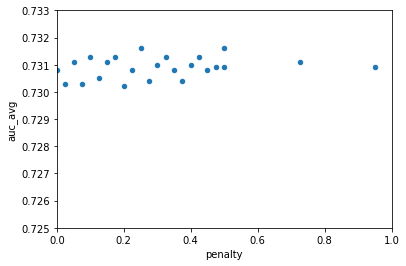

In [61]:
res.plot.scatter('penalty', 'auc_avg', xlim=(0, 1), ylim=(0.725, 0.733))

In [36]:
res = res.loc[res.md_width>100]

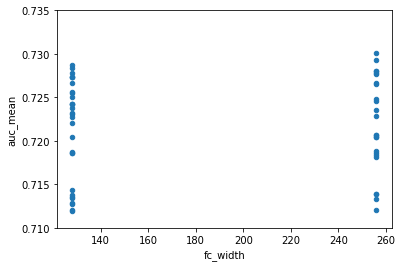

In [11]:
res.plot.scatter('fc_width', 'auc_mean', ylim=(0.71, 0.735))

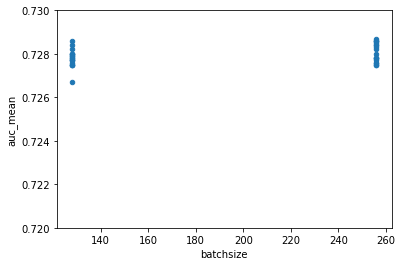

In [40]:
res.plot.scatter('batchsize', 'auc_mean', ylim=(0.72, 0.73))

In [17]:
res.loc[res.auc_mean==res.auc_mean.max(), ['embed_file', 'y_pred_file', 'auc_mean']]

,embed_file,y_pred_file,auc_mean
5,all/embed_mat_pen6e-7.npy,output/y_pred_mat18_08_30_01_34_24.npy,0.7282
8,all/embed_mat_pen9e-7.npy,output/y_pred_mat18_08_30_03_43_48.npy,0.7282


In [43]:
res.loc[res.auc_mean>0.7285, ]

,model_name,code_embed_dim,hosp_embed_dim,fc_width,md_width,lr1,lr2,dropout,batchsize,embed_file,data_file,sep_dx1,tst_seed,n_fold,auc_mean,auc_cil,auc_cih,y_pred_file
26,setsum,100,1,128,128,0.0002,0.00002,0.1,128,all/embed_mat_pen_2_1e-6.npy,cohorts/ami/ami_pred.csv,0,0,7,0.7286,(0.7275,0.7298),output/y_pred_mat18_08_30_11_48_48.npy
35,setsum,100,1,128,256,0.0002,0.00005,0.3,256,all/embed_mat_pen_2_1e-6.npy,cohorts/ami/ami_pred.csv,0,0,7,0.7286,(0.7278,0.7295),output/y_pred_mat18_08_30_06_42_42.npy
24,setsum,100,1,128,128,0.0002,0.00001,0.1,256,all/embed_mat_pen_2_1e-6.npy,cohorts/ami/ami_pred.csv,0,0,7,0.7287,(0.7275,0.7300),output/y_pred_mat18_08_30_11_59_33.npy
34,setsum,100,1,128,256,0.0002,0.00005,0.1,256,all/embed_mat_pen_2_1e-6.npy,cohorts/ami/ami_pred.csv,0,0,7,0.7286,(0.7271,0.7301),output/y_pred_mat18_08_30_08_38_31.npy
27,setsum,100,1,128,128,0.0002,0.00002,0.5,256,all/embed_mat_pen_2_1e-6.npy,cohorts/ami/ami_pred.csv,0,0,7,0.7286,(0.7278,0.7294),output/y_pred_mat18_08_30_12_04_01.npy


### Embedding + NN  with subset of codes

In [4]:
res = pd.DataFrame()

In [4]:
for job_ind in range(4):
    df = pd.read_csv('output/ht_result1001_'+str(job_ind)+'.csv', 
                     names=['model_name', 'code_embed_dim', 'hosp_embed_dim', 'fc_width', 'md_width', 'lr1', 'lr2', 'dropout',
                            'batchsize', 'embed_file', 'cohort', 'tst_seed', 'n_fold', 'penalty', 'penalty_metric', 'count_cap', 
                            'DX_rarecutpoint', 'PR_rarecutpoint', 'auc_mean', 'auc_avg', 'auc_freeze', 'y_pred_file'], index_col=None)
    res = pd.concat([res, df])

In [4]:
res = res.loc[res.model_name=='embed_sum']

In [8]:
res

,model_name,code_embed_dim,hosp_embed_dim,fc_width,md_width,lr1,lr2,dropout,batchsize,embed_file,...,n_fold,penalty,penalty_metric,count_cap,DX_rarecutpoint,PR_rarecutpoint,auc_mean,auc_avg,auc_freeze,y_pred_file
0,setsum_nn,200,1,1024,256,0.0002,0.00002,0.3,256,pretrain,...,5,1.0,cosine,5,20,10,0.71854,0.72020,0.71711,output/y_pred_mat18_10_03_04_03_11.npy
1,setsum_nn,200,1,1024,256,0.0002,0.00002,0.3,256,pretrain,...,5,1.0,cosine,5,20,10,0.71977,0.72173,0.71875,output/y_pred_mat18_10_03_04_32_18.npy
2,setsum_nn,200,1,1024,256,0.0002,0.00002,0.3,256,pretrain,...,5,1.0,cosine,5,20,10,0.72522,0.72696,0.72325,output/y_pred_mat18_10_03_05_02_18.npy
3,setsum_nn,200,1,512,256,0.0002,0.00002,0.3,256,pretrain,...,5,0.0,cosine,5,20,10,0.71286,0.71549,0.71256,output/y_pred_mat18_10_03_05_34_03.npy
4,setsum_nn,200,1,512,256,0.0002,0.00002,0.3,256,pretrain,...,5,0.0,cosine,5,20,10,0.70873,0.71141,0.70968,output/y_pred_mat18_10_03_06_07_20.npy
5,setsum_nn,300,1,1024,256,0.0002,0.00002,0.3,512,pretrain,...,5,0.0,cosine,0,20,10,0.71711,0.71959,0.71640,output/y_pred_mat18_10_03_06_30_57.npy
6,setsum_nn,300,1,1024,256,0.0002,0.00002,0.3,512,pretrain,...,5,0.0,cosine,0,20,10,0.71793,0.72071,0.71688,output/y_pred_mat18_10_03_06_56_58.npy
7,setsum_nn,300,1,1024,256,0.0002,0.00002,0.3,512,pretrain,...,5,0.0,cosine,0,20,10,0.72293,0.72548,0.72196,output/y_pred_mat18_10_03_07_22_56.npy
8,setsum_nn,300,1,1024,256,0.0002,0.00002,0.3,512,pretrain,...,5,0.0,cosine,0,20,10,0.71236,0.71453,0.71221,output/y_pred_mat18_10_03_07_46_51.npy
9,setsum_nn,300,1,1024,256,0.0002,0.00002,0.3,512,pretrain,...,5,0.0,cosine,0,20,10,0.70821,0.71076,0.70844,output/y_pred_mat18_10_03_08_11_43.npy


In [10]:
res_grouped = res.groupby(['code_embed_dim', 'fc_width', 'md_width', 'penalty', 'batchsize', 'count_cap'])

In [11]:
res_grouped[['auc_freeze', 'auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_freeze        \
                                                                   mean count   
code_embed_dim fc_width md_width penalty batchsize count_cap                    
200            512      128      0.0     256       20          0.716274    20   
                                         512       0           0.716043    20   
                        256      0.0     256       5           0.716623    10   
               1024     128      0.0     256       5           0.716075    20   
                                                   20          0.716289    10   
                                         512       5           0.716510    10   
300            1024     256      0.0     512       0           0.715975    20   

                                                              auc_mean        \
                                                                  mean count   
code_embed_dim fc_width md_width penalty batchsize count_cap                   
200            512      128      0.0     256       20         0.717040    20   
                                         512       0          0.716647    20   
                        256      0.0     256       5          0.717226    10   
               1024     128      0.0     256       5          0.716861    20   
                                                   20         0.717320    10   
                                         512       5          0.717119    10   
300            1024     256      0.0     512       0          0.716324    20   

                                                               auc_avg        
                                                                  mean count  
code_embed_dim fc_width md_width penalty batchsize count_cap                  
200            512      128      0.0     256       20         0.719784    20  
                                         512       0          0.719599    20  
                        256      0.0     256       5          0.719562    10  
               1024     128      0.0     256       5          0.719762    20  
                                                   20         0.719926    10  
                                         512       5          0.720019    10  
300            1024     256      0.0     512       0          0.718935    20

In [16]:
res.to_csv('output/ht_result1003embed_nn_sub.csv', index=False)

In [5]:
res = pd.read_csv('output/ht_result1003embed_nn_sub.csv')

In [9]:
res = res.loc[res.penalty==0]

### OHE models

In [34]:
res = pd.DataFrame()

In [35]:
for job_ind in range(1):
    df = pd.read_csv('output/ht_result0925_'+str(job_ind)+'.csv', 
                     names=['fc_width1', 'fc_width2', 'lr', 'dropout', 'batchsize', 'cohort', 'tst_seed', 'n_fold', 
                            'DX_rarecutpoint', 'PR_rarecutpoint', 'auc_mean', 'auc_avg', 'y_pred_file'], index_col=None)
    res = pd.concat([res, df])

In [36]:
res

,fc_width1,fc_width2,lr,dropout,batchsize,cohort,tst_seed,n_fold,DX_rarecutpoint,PR_rarecutpoint,auc_mean,auc_avg,y_pred_file
0,1024,256,0.0001,0.3,512,ami,0,5,10,10,0.71339,0.71610,output/y_pred_mat18_09_26_12_37_55.npy
1,1024,256,0.0001,0.3,512,chf,0,5,10,10,0.61783,0.62129,output/y_pred_mat18_09_26_12_50_49.npy
2,1024,256,0.0001,0.3,512,pna,0,5,10,10,0.66755,0.67043,output/y_pred_mat18_09_26_01_14_10.npy
3,1024,256,0.0001,0.3,512,ami,1,5,10,10,0.71938,0.72227,output/y_pred_mat18_09_26_01_20_51.npy
4,1024,256,0.0001,0.3,512,chf,1,5,10,10,0.62258,0.62686,output/y_pred_mat18_09_26_01_34_06.npy
5,1024,256,0.0001,0.3,512,pna,1,5,10,10,0.67248,0.67472,output/y_pred_mat18_09_26_01_56_41.npy
6,1024,256,0.0001,0.3,512,ami,2,5,10,10,0.70725,0.71013,output/y_pred_mat18_09_26_02_03_15.npy
7,1024,256,0.0001,0.3,512,chf,2,5,10,10,0.62727,0.63157,output/y_pred_mat18_09_26_02_16_32.npy
8,1024,256,0.0001,0.3,512,pna,2,5,10,10,0.66761,0.67088,output/y_pred_mat18_09_26_02_39_27.npy
9,1024,256,0.0001,0.3,512,ami,3,5,10,10,0.71382,0.71638,output/y_pred_mat18_09_26_02_46_03.npy


In [37]:
res_grouped = res.groupby(['cohort'])

In [39]:
res_grouped[['auc_mean', 'auc_avg']].agg(['mean', 'count'])

auc_mean         auc_avg      
            mean count      mean count
cohort                                
ami     0.713779    10  0.716431    10
chf     0.625169    10  0.629076    10
pna     0.667465    10  0.670033    10

In [40]:
for n, g in res_grouped:
    print(n, 'mean: {0:.4f} ({1:.4f})'.format(g.auc_mean.mean(), g.auc_mean.std()/np.sqrt(len(g))), 
         'avg: {0:.4f} ({1:.4f})'.format(g.auc_avg.mean(), g.auc_avg.std()/np.sqrt(len(g))))

ami mean: 0.7138 (0.0016) avg: 0.7164 (0.0016)
chf mean: 0.6252 (0.0013) avg: 0.6291 (0.0013)
pna mean: 0.6675 (0.0012) avg: 0.6700 (0.0011)
